# Experiment description
## Hypothesis: 
Hitrate vs. coverage plot depicts a logaritmic curve. For coverages bigger than 10% there is not a significant increment on hitrates

## Method: 

Estimate hitrates using different coverages values. Experiment parameters:
- Use city trained model between 2017-01-01 and 2017-01-21
- Predict for 2017-01-24 at 21:00 (according to experiment 07, this was the day with higher hitrates)
- Coverage values [0.01 , 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.12, 0.14, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

## Results:
- Plot depicts a logaritmic curve.
- For coverages bigger than 50% there is not a significant increment on hitrates.

In [2]:
%matplotlib inline
import pandas as pd
import pickle
import dateutil.parser
import pyproj
import open_cp
from PIL import Image
import datetime
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import import_ipynb
import training_sepp_builtin

importing Jupyter notebook from training_sepp_builtin.ipynb
  Using cached https://github.com/QuantCrimAtLeeds/PredictCode/zipball/master
  Created wheel for opencp: filename=opencp-0.2.0-cp37-none-any.whl size=280058 sha256=8074197a80690b2b19e16ae0b16ba0b68c44ae36b00e17eeef0d9c604b73cb2c
  Stored in directory: /tmp/pip-ephem-wheel-cache-6o9vdfpp/wheels/9a/f6/1f/9ea8bd2ac044e7df5c432f658ba156f0cfc3540891a5bad62a
Successfully built opencp
  Using cached https://github.com/MatthewDaws/SEPP/zipball/master
  Created wheel for sepp: filename=sepp-0.9.0-cp37-none-any.whl size=37591 sha256=2a3334ac55af1ec022d39b97a5a1f77e07ea6f12e1ef342d721cdd2b70c23671
  Stored in directory: /tmp/pip-ephem-wheel-cache-vabhmgh5/wheels/1d/e6/94/444aa295403d7f0e2ffd698d822abc6a4427daa85f8c5cb0b0
Successfully built sepp


Failed to load 'descartes' package.


In [4]:
def selectDataPrediction(nameLoc,dateIni,dateEnd):
    if nameLoc == 'city':
        dfloc = df
    else:
        dfloc = df[df["LOCALIDAD"]==nameLoc]
            
    dfloc["FECHA_HORA"]=dfloc["HORA"].astype(str)
    valHour = dfloc["FECHA_HORA"].values
    valDate = dfloc["FECHA"].values
    timesVals = [];
    k = 0;
    for i in valHour:
        if len(i)<=2:
            timeStr = valDate[k] +" " + "00:"+i+":00"
        else:
            timeStr = valDate[k] +" " + i[:-2]+":"+i[-2:]+":00"
        
        k = k + 1

        timesVals.append(timeStr)
    dfloc["FECHA_HORA"] = timesVals;
    
    dfloc["FECHA_HORA_TS"] = dfloc.FECHA_HORA.map(dateutil.parser.parse)
    dfFilter = dfloc[(dfloc.FECHA_HORA_TS > dateIni) & (dfloc.FECHA_HORA_TS < dateEnd)]
    timestamps = dfFilter.FECHA_HORA_TS
    
    print("TimeStamps")
    print(type(timestamps))
    print([timestamps])

    xcoords, ycoords = (dfFilter.LONGITUD.values,dfFilter.LATITUD.values)
    proj = pyproj.Proj(init="EPSG:3116")
    xcoords, ycoords = proj(xcoords,ycoords)
    
    points_crime = open_cp.TimedPoints.from_coords(timestamps, xcoords, ycoords)
    
    #Generando Grilla para los algoritmos. 
    maxx = max(xcoords)
    minx = min(xcoords)
    maxy = max(ycoords)
    miny = min(ycoords)
    #print(maxx,minx,maxy,miny)

    region = open_cp.RectangularRegion(xmin=minx, xmax=maxx, ymin=miny, ymax=maxy)
    #print(region)
    
    return (points_crime,region)


In [5]:
def load_model(localidad, experiment_name):
    custom_path = path+'/aggressive_behavior_model/SEPP/'+'pkl/TrainRina_'+experiment_name+'.pkl'
    infile = open(custom_path,'rb')
    modelCrime = pickle.load(infile)
    infile.close()
    return modelCrime

In [7]:
def sweep_coverages_prediction(localidad,modelCrime,time_window_prediction,predict_time,coverages):
    points_crime,region = selectDataPrediction(localidad,time_window_prediction['start'],time_window_prediction['end'])
    modelCrime.data = points_crime 
    prediction = modelCrime.predict(predict_time)
    gridpred = open_cp.predictors.GridPredictionArray.from_continuous_prediction_region(prediction, region, 150, 150)
    hitrates = open_cp.evaluation.hit_rates(gridpred, points_crime, [coverages[0],coverages[1]])
    return gridpred, hitrates

In [6]:
def plot_gridpred(localidad,predict_time,gridpred):
    fig, ax = plt.subplots(figsize=(20,10))
    m = ax.pcolormesh(*gridpred.mesh_data(), gridpred.intensity_matrix, cmap="CMRmap_r")
    ax.set_title("Predicción localidad: "+localidad+'; fecha: '+str(predict_time))
    fig.colorbar(m, ax=ax)

## Select data

In [8]:
path = '/u01/user8/Documents/Riñas'

In [9]:
df = pd.read_csv(path+'/datasets/verify_enrich_nuse_29112019.csv')

## Test prediction

In [10]:
localidad = 'city'
parameters = {"time_bw":144,"space_bw":50,"time_cutoff":90,"space_cutoff":500}
train_initial_date = '2017-01-01'
train_final_date = '2017-01-22'
trained_model_name = str(localidad)+'_'+train_initial_date+'_'+train_final_date+'_time_cutoff_'+str(parameters['time_cutoff'])

In [24]:
initial_date_prediction = '2017-01-24'
end_date = datetime.datetime.strptime(initial_date_prediction,'%Y-%m-%d')+datetime.timedelta(days=1)
end_date = end_date.strftime('%Y-%m-%d')
time_window_prediction = {'start':initial_date_prediction,'end':end_date}
hour_value = 21

In [ ]:
coverage_values = [0.01 , 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.12, 0.14, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

In [ ]:
flagF = True
modelCrime = load_model(localidad,trained_model_name)
current_date_prediction = time_window_prediction['start']
predict_time = datetime.datetime.strptime(current_date_prediction,'%Y-%m-%d')+datetime.timedelta(hours=hour_value)
coverages = []

for i,j in zip(coverage_values[0::2], coverage_values[1::2]):
    print(str(i), '+', str(j))
    coverages = []
    coverages.append(i)
    coverages.append(j)
    print(coverages[0],coverages[1])
    gridpred, hitrates = sweep_coverages_prediction(localidad,modelCrime,time_window_prediction,predict_time,coverages)
    #plot_gridpred(localidad,predict_time,gridpred) ## uncomment to plot gridpred
    if flagF==True:
        flagF = False
        hitrates_values = np.array([localidad,predict_time.strftime('%Y-%m-%d %H:%M:%S'),i,hitrates[i]])
        hitrates_values = np.vstack((hitrates_values, [localidad,predict_time.strftime('%Y-%m-%d %H:%M:%S'),j,hitrates[j]]))
    else:
        hitrates_values = np.vstack((hitrates_values, [localidad,predict_time.strftime('%Y-%m-%d %H:%M:%S'),i,hitrates[i]]))
        hitrates_values = np.vstack((hitrates_values, [localidad,predict_time.strftime('%Y-%m-%d %H:%M:%S'),j,hitrates[j]]))
    
    print(hitrates_values)


In [26]:
df_hitrates = pd.DataFrame(hitrates_values, columns=['localidad','prediction_time','coverage','hitrate'])
df_hitrates

,localidad,prediction_time,coverage,hitrate
0,city,2017-01-24 21:00:00,0.01,0.0084985835694051
1,city,2017-01-24 21:00:00,0.02,0.0169971671388102
2,city,2017-01-24 21:00:00,0.03,0.0226628895184136
3,city,2017-01-24 21:00:00,0.04,0.029745042492917848
4,city,2017-01-24 21:00:00,0.05,0.03541076487252125
5,city,2017-01-24 21:00:00,0.06,0.04107648725212465
6,city,2017-01-24 21:00:00,0.07,0.056657223796033995
7,city,2017-01-24 21:00:00,0.08,0.06657223796033994
8,city,2017-01-24 21:00:00,0.09,0.060906515580736544
9,city,2017-01-24 21:00:00,0.1,0.06515580736543909


In [27]:
experiment_name = 'city_coverage_vs_hitrate_2017-01-24'
hitrates_outfile = open(path+'/aggressive_behavior_model/SEPP/'+'pkl/PredictionRina_'+experiment_name+'.pkl','wb')
pickle.dump(df_hitrates, hitrates_outfile)
hitrates_outfile.close()

## Plot results

In [29]:
df_hitrates['coverage'] = pd.to_numeric(df_hitrates['coverage'])
df_hitrates['hitrate'] = pd.to_numeric(df_hitrates['hitrate'])

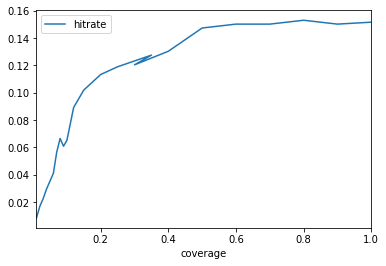

In [30]:
df_hitrates.plot(x='coverage', y='hitrate')


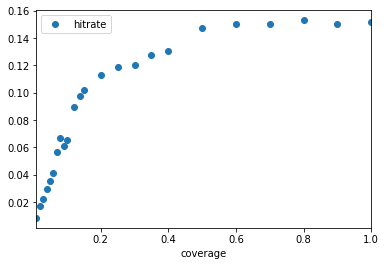

In [31]:
df_hitrates.plot(x='coverage', y='hitrate', style='o')